In [1]:
import glob
import os
import json

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import cPickle as pkl


from pipeline.python.classifications import experiment_classes as util


import scipy.stats as spstats

from pipeline.python.utils import label_figure, natural_keys
from pipeline.python.classifications import bootstrap_osi as osi
from pipeline.python.classifications import get_dataset_stats as gd

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/applica

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/retinotopy/fit_2d_rfs.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", lin

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/retinotopy/target_visual_field.py:19: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application

In [2]:
reload(osi)
reload(util)

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/applica

<module 'pipeline.python.classifications.experiment_classes' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.pyc'>

# Get session info

In [3]:
options = ['-t', 'traces001']

optsE = gd.extract_options(options)


rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type

print aggregate_dir

/n/coxfs01/julianarhee/aggregate-visual-areas


In [4]:
sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = gd.aggregate_session_info(traceid=optsE.traceid, trace_type=optsE.trace_type, 
                                       state=optsE.state, fov_type=optsE.fov_type, 
                                       visual_areas=optsE.visual_areas,
                                       blacklist=optsE.blacklist, 
                                       rootdir=optsE.rootdir)
    with open(sdata_fpath, 'wb') as f:
        pkl.dump(sdata, f, protocol=pkl.HIGHEST_PROTOCOL)

In [5]:
sdata.head()

,animalid,experiment,fov,session,visual_area,exp_no,animal_no
0,JC084,rfs,FOV1_zoom2p0x,20190522,V1,3,4
1,JC084,gratings,FOV1_zoom2p0x,20190522,V1,1,4
2,JC084,blobs,FOV1_zoom2p0x,20190522,V1,0,4
3,JC084,retino,FOV1_zoom2p0x,20190522,V1,2,4
4,JC084,rfs,FOV1_zoom2p0x,20190525,Lm,3,4


In [6]:
dsets = sdata[sdata['experiment']=='gratings']

In [7]:
traceid = 'traces001'

response_type = 'dff'
responsive_test = 'nstds' #'nstds' #'ROC'
responsive_thr = 10 #0.05
n_bootstrap_iters=1000
n_resamples = 20

In [8]:
fit_desc = osi.get_fit_desc(response_type=response_type, responsive_test=responsive_test, responsive_thr=responsive_thr,
                            n_bootstrap_iters=n_bootstrap_iters, n_resamples=n_resamples)
print fit_desc

fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


In [9]:
aggregate_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas'

In [10]:
destdir = os.path.join(aggregate_dir, 'orientation-tuning', '%s-%s' % (traceid, fit_desc))
print(destdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/orientation-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20


In [11]:
aggstats_fpath = glob.glob(os.path.join(destdir, '*.pkl'))[0]
with open(aggstats_fpath, 'rb') as f:
    stats = pkl.load(f)
#stats

In [12]:
[(skey, len(vals)) for skey, vals in stats.items() if not isinstance(vals, int)]

[('JC080_20190603_FOV1_zoom2p0x', 16),
 ('JC090_20190605_FOV1_zoom2p0x', 2),
 ('JC091_20190602_FOV1_zoom2p0x', 6),
 ('JC091_20190627_FOV1_zoom2p0x', 9),
 ('JC083_20190517_FOV1_zoom2p0x', 4),
 ('JC097_20190617_FOV1_zoom2p0x', 9),
 ('JC097_20190616_FOV1_zoom2p0x', 29),
 ('JC083_20190511_FOV1_zoom2p0x', 36),
 ('JC083_20190512_FOV1_zoom2p0x', 25),
 ('JC084_20190525_FOV1_zoom2p0x', 15),
 ('JC091_20190606_FOV1_zoom2p0x', 2),
 ('JC099_20190612_FOV1_zoom2p0x', 4),
 ('JC085_20190622_FOV1_zoom2p0x', 22),
 ('JC091_20190607_FOV1_zoom2p0x', 4),
 ('JC097_20190613_FOV1_zoom2p0x', 10),
 ('JC084_20190522_FOV1_zoom2p0x', 28),
 ('JC091_20190614_FOV1_zoom2p0x', 6),
 ('JC078_20190513_FOV1_zoom2p0x', 34)]

In [13]:
[(skey, len(vals)) for skey, vals in stats.items() if not isinstance(vals, int)]

[('JC080_20190603_FOV1_zoom2p0x', 16),
 ('JC090_20190605_FOV1_zoom2p0x', 2),
 ('JC091_20190602_FOV1_zoom2p0x', 6),
 ('JC091_20190627_FOV1_zoom2p0x', 9),
 ('JC083_20190517_FOV1_zoom2p0x', 4),
 ('JC097_20190617_FOV1_zoom2p0x', 9),
 ('JC097_20190616_FOV1_zoom2p0x', 29),
 ('JC083_20190511_FOV1_zoom2p0x', 36),
 ('JC083_20190512_FOV1_zoom2p0x', 25),
 ('JC084_20190525_FOV1_zoom2p0x', 15),
 ('JC091_20190606_FOV1_zoom2p0x', 2),
 ('JC099_20190612_FOV1_zoom2p0x', 4),
 ('JC085_20190622_FOV1_zoom2p0x', 22),
 ('JC091_20190607_FOV1_zoom2p0x', 4),
 ('JC097_20190613_FOV1_zoom2p0x', 10),
 ('JC084_20190522_FOV1_zoom2p0x', 28),
 ('JC091_20190614_FOV1_zoom2p0x', 6),
 ('JC078_20190513_FOV1_zoom2p0x', 34)]

In [12]:
[(skey, len(vals)) for skey, vals in stats.items()]

TypeError: object of type 'int' has no len()

# Aggregate all tuning data

In [14]:
%matplotlib notebook

In [79]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

In [80]:
# animalid = 'JC084'
# session ='20190522'

In [81]:
rootdir = '/n/coxfs01/2p-data'
# fov_type = 'zoom2p0x'


In [82]:
def get_average_tuning_over_iters(fitdf):
    means = {}
    roi = int(fitdf['cell'].unique()[0])
    for param in fitdf.columns:
        if 'theta' in param:
            meanval = np.rad2deg(spstats.circmean(np.deg2rad(fitdf[param].values % 360.)))
        else:
            meanval = fitdf[param].values.mean()
        
        means[param] = meanval
    
    return pd.DataFrame(means, index=[roi])

In [19]:
import copy

# Select data

## IGNORE THESE:
##### V1:  JC076-20190501, JC083-20190510
    - if rfs only, ignore: JC083-20190510, JC083-20190511, 
    
    - if blobs & rfs only, ignore: JC083_20190510, JC083-20190511
    
    - if ALL stimuli, ignore: JC083-20190507, JC083-20190510, 
    
#### Lm:  JC078-20190509, JC080-20190506, JC083-20190517
    - if rfs only, ignore: JC078-20190504, JC078-2019513, 
                           JC083-20190512

    - if blobs & rfs: ignore: JC078-20190426, JC078-2019513
                              JC083-20190512
                              
    - if ALL stimuli, ignore: JC078-20190430, JC078-20190426, JC078-20190504
                              JC083-20190508
#### Li:  JC076-20190422, JC099-20190509, JC091-20190607, JC091-20190606

In [22]:
always_exclude = ['JC076-20190501', 'JC083-20190510', 
                  'JC078-20190426', 'JC078-20190509', 'JC080-20190506', 'JC083-20190517',
                 'JC076-20190422', 'JC099-20190509', 'JC091-20190607', 'JC091-20190606']
# also_exclude = ['JC083-20190511', 
#                 'JC078-2019513', 'JC083-20190512']
also_exclude = ['JC083-20190507', 'JC083-20190510',
                'JC078-2019430', 'JC078-20190426',  'JC078-20190504', 'JC083-20190508']
            


excluded_sessions = copy.copy(always_exclude)
excluded_sessions.extend(also_exclude)
print(len(excluded_sessions))

16


# Test with 1 dataset first

In [23]:
animalid = 'JC097'
session = '20190616'
fov = 'FOV1_zoom2p0x'


In [24]:
gof_thr=0.6
bootresults, fitparams = osi.load_tuning_results(animalid, session, fov, 'combined_gratings_static', \
                                                 traceid, fit_desc)
rmetrics, rmetrics_by_cfg = osi.get_good_fits(bootresults, fitparams, gof_thr=gof_thr)
print("%i cells with good fits." % rmetrics.shape[0])

Loading existing fits.
141 cells fit at least 1 tuning curve.


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/bootstrap_osi.py:1230: RuntimeWarning: invalid value encountered in sqrt
  gfit = np.mean(bootr['results']['r2']) * (1-iqr) * np.sqrt(r2_comb)


43 cells with good fits.


In [25]:
dsets = sdata[sdata['experiment']=='gratings']

In [26]:
gof_thr = 0.6

In [27]:
cellcounts = {}


for (visual_area, animalid, session, fov), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fov']):
    skey = '%s_%s' % (visual_area, '-'.join([animalid, session, fov]) )

    exp = util.Gratings(animalid, session, fov, traceid=traceid, rootdir=rootdir)
    roi_list, _ = exp.get_responsive_cells(responsive_test=responsive_test, responsive_thr=5)
    bootresults, fitparams = exp.get_tuning(response_type=response_type,
                                           responsive_test=responsive_test,
                                           responsive_thr=responsive_thr,
                                           n_stds=2.5,
                                           n_bootstrap_iters=n_bootstrap_iters,
                                           n_resamples=n_resamples,
                                           n_processes=8, make_plots=True)

#     bootresults, fitparams = osi.load_tuning_results(animalid, session, fov, 'combined_gratings_static', \
#                                                      traceid, fit_desc)
    rmetrics, rmetrics_by_cfg = osi.get_good_fits(bootresults, fitparams, gof_thr=gof_thr)
    if rmetrics is None:
        continue
    assert all([r in roi_list for r in rmetrics.index.tolist()]), "STH FUNKY"
    cellcounts[skey] = (rmetrics.shape[0], len(roi_list))

... [JC090|20190605|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... getting responsive cells (test: nstds, thr: 5.00')
...getting OSI results: fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20
Loading existing fits.
25 cells fit at least 1 tuning curve.
... [JC091|20190602|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... getting responsive cells (test: nstds, thr: 5.00')
...getting OSI results: fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20
Loading existing fits.
69 cells fit at least 1 tuning curve.
... [JC091|20190606|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... getting responsive cells (test: nstds, thr: 5.00')
...getting OSI results: fit-dff_responsive-nstds-2.50-thr

In [22]:
cellcounts

{'Li_JC090-20190605-FOV1_zoom2p0x': (5, 139),
 'Li_JC091-20190602-FOV1_zoom2p0x': (12, 262),
 'Li_JC091-20190606-FOV1_zoom2p0x': (4, 99),
 'Li_JC091-20190607-FOV1_zoom2p0x': (7, 297),
 'Li_JC091-20190614-FOV1_zoom2p0x': (8, 276),
 'Li_JC099-20190609-FOV1_zoom2p0x': (1, 145),
 'Li_JC099-20190612-FOV1_zoom2p0x': (5, 149),
 'Lm_JC078-20190513-FOV1_zoom2p0x': (39, 271),
 'Lm_JC080-20190603-FOV1_zoom2p0x': (20, 212),
 'Lm_JC083-20190512-FOV1_zoom2p0x': (27, 348),
 'Lm_JC083-20190517-FOV1_zoom2p0x': (5, 127),
 'Lm_JC084-20190525-FOV1_zoom2p0x': (17, 168),
 'Lm_JC091-20190627-FOV1_zoom2p0x': (11, 120),
 'V1_JC083-20190511-FOV1_zoom2p0x': (43, 166),
 'V1_JC084-20190522-FOV1_zoom2p0x': (36, 223),
 'V1_JC085-20190622-FOV1_zoom2p0x': (30, 204),
 'V1_JC097-20190613-FOV1_zoom2p0x': (11, 135),
 'V1_JC097-20190616-FOV1_zoom2p0x': (43, 295),
 'V1_JC097-20190617-FOV1_zoom2p0x': (9, 223)}

In [30]:
excluded_sessions

['JC076-20190501',
 'JC083-20190510',
 'JC078-20190426',
 'JC078-20190509',
 'JC080-20190506',
 'JC083-20190517',
 'JC076-20190422',
 'JC099-20190509',
 'JC091-20190607',
 'JC091-20190606',
 'JC083-20190507',
 'JC083-20190510',
 'JC078-2019430',
 'JC078-20190426',
 'JC078-20190504',
 'JC083-20190508']

In [31]:
visual_areas = ['V1', 'Lm', 'Li']

In [32]:
'-'.join(k.split('_')[1].split('-')[0:2])

NameError: name 'k' is not defined

In [33]:
[k.split('_')[1].split('-')[0:2]]

NameError: name 'k' is not defined

In [34]:
fracs = []
for visual_area in visual_areas:
    sk = [k for k, v in cellcounts.items() if k.split('_')[0]==visual_area \
         and '-'.join(k.split('_')[1].split('-')[0:2]) not in excluded_sessions]
    total = np.sum([cellcounts[k][0] for k in sk])
    print "%s: %i" % (visual_area, total)
    

V1: 172
Lm: 114
Li: 31


In [35]:
fracs = []
for visual_area in visual_areas:
    fvs = [float(v[0])/float(v[1]) for k, v in cellcounts.items() if k.split('_')[0]==visual_area]
    fracs.append(pd.DataFrame({'fraction': fvs,
                  'visual_area': [visual_area for _ in range(len(fvs))]}))
    

In [36]:
fracs = pd.concat(fracs)

In [37]:
%matplotlib notebook

In [38]:
fracs

,fraction,visual_area
0,0.145763,V1
1,0.161435,V1
2,0.081481,V1
3,0.147059,V1
4,0.259036,V1
5,0.040359,V1
0,0.091667,Lm
1,0.101190,Lm
2,0.143911,Lm
3,0.077586,Lm


In [39]:
destdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/orientation-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20'

<IPython.core.display.Javascript object>


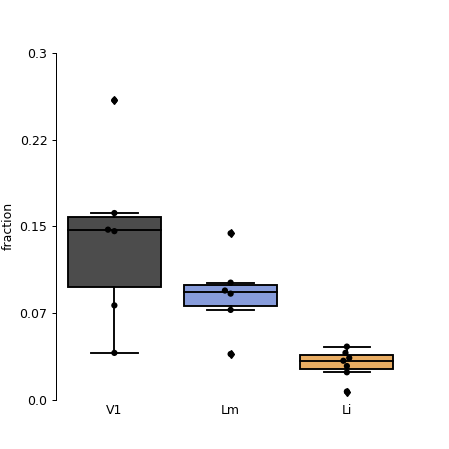

In [53]:
fig, ax = pl.subplots(figsize=(5,5))

ax = sns.boxplot(x="visual_area", y="fraction", data=fracs, palette=area_colors, ax=ax) #,\
                 #notch=True, bootstrap=10000)
ymax = round(ax.get_ylim()[-1], 1)
ax.set_ylim([0, ymax])
ax.set_yticks(np.linspace(0, ymax, 5))
ax.set_yticklabels([round(i, 2) for i in np.linspace(0, ymax, 5)])

for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .7))
    
sns.swarmplot(x='visual_area', y='fraction', data=fracs, ax=ax, color='k', s=5, marker='o') #palette=area_colors)
sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', length=0)
ax.set_xlabel('')

pl.savefig(os.path.join(destdir, 'fraction-tuned_gof-%.2f.svg' % gof_thr))

In [42]:
c1 = fracs[fracs['visual_area']=='V1']['fraction'].values
c2 = fracs[fracs['visual_area']=='Lm']['fraction'].values
c3 = fracs[fracs['visual_area']=='Li']['fraction'].values

In [43]:
c1

array([0.14576271, 0.16143498, 0.08148148, 0.14705882, 0.25903614,
       0.04035874])

In [44]:
# Shapiro-Wilk normality test 
spstats.shapiro(c1), spstats.shapiro(c2), spstats.shapiro(c3) 

((0.9487103223800659, 0.7298258543014526),
 (0.9527366757392883, 0.76237553358078),
 (0.9400163292884827, 0.6388666033744812))

In [45]:

# Levene variance test  
spstats.levene(c1, c2, c3)

LeveneResult(statistic=2.6657326388036955, pvalue=0.10018307387090222)

In [46]:


F, p = spstats.f_oneway(c1, c2, c3)
print('F statistic = {:5.3f} and probability p = {:5.3f}'.format(F, p)) 

F statistic = 8.840 and probability p = 0.003


In [47]:
scores = np.hstack([c1, c2, c3])
groups = np.hstack([['V1' for _ in range(len(c1))], 
                   ['Lm' for _ in range(len(c2))],
                   ['Li' for _ in range(len(c3))]])
print(scores.shape)
print(groups.shape)

(19,)
(19,)


In [48]:
import statsmodels.stats.multicomp as ml

# Note that data in sheet have been preformatted in Group and Score columns 
# Boolean values refer to whether we should reject the null hypothesis (H0) that
# the means of the tested pair are statistically similar (non-significant differences)

mcobj = ml.MultiComparison(scores, groups)
out = mcobj.tukeyhsd(0.05) 

print(out)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Li     Lm    0.0606  -0.0063 0.1275 False 
  Li     V1    0.1084   0.0415 0.1754  True 
  Lm     V1    0.0478  -0.0216 0.1173 False 
--------------------------------------------


In [49]:
print gof_thr

0.6


In [50]:
gdata = []
for (visual_area, animalid, session, fov), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fov']):
    
    bootresults, fitparams = osi.load_tuning_results(animalid, session, fov, 'combined_gratings_static', \
                                                     traceid, fit_desc)
    rmetrics, rmetrics_by_cfg = osi.get_good_fits(bootresults, fitparams, gof_thr=gof_thr)
    if rmetrics is None:
        continue
    print("%i cells with good fits." % rmetrics.shape[0])

    meandf = pd.concat([rmetrics_by_cfg.groupby(['cell']).get_group(roi).sort_values(by=['asi','dsi'],ascending=False).iloc[0]\
           for roi in rmetrics['cell'].unique()], axis=1).T

    ncells = meandf.shape[0]
    meandf['visual_area'] = [visual_area for _ in range(ncells)]
    meandf['animalid'] = [animalid for _ in range(ncells)]
    meandf['session'] = [session for _ in range(ncells)]
    meandf['fov'] = [fov for _ in range(ncells)]
    
    gdata.append(meandf)
        

Loading existing fits.
25 cells fit at least 1 tuning curve.
5 cells with good fits.
Loading existing fits.
69 cells fit at least 1 tuning curve.
12 cells with good fits.
Loading existing fits.
19 cells fit at least 1 tuning curve.
4 cells with good fits.
Loading existing fits.
53 cells fit at least 1 tuning curve.
7 cells with good fits.
Loading existing fits.
49 cells fit at least 1 tuning curve.
8 cells with good fits.
Loading existing fits.
12 cells fit at least 1 tuning curve.
1 cells with good fits.
Loading existing fits.
34 cells fit at least 1 tuning curve.
5 cells with good fits.
Loading existing fits.
5 cells fit at least 1 tuning curve.
Loading existing fits.
165 cells fit at least 1 tuning curve.
39 cells with good fits.
Loading existing fits.
78 cells fit at least 1 tuning curve.
20 cells with good fits.
Loading existing fits.
169 cells fit at least 1 tuning curve.
27 cells with good fits.
Loading existing fits.
15 cells fit at least 1 tuning curve.
5 cells with good fits.

In [51]:
gdata = pd.concat(gdata, axis=0)

In [52]:
gdata.shape

(333, 15)

# Visualize

In [55]:
def compare_tuning_metric(df, metric='ASI', cdf=False, ax=None, area_colors=None, show_legend=True, alpha=1):
    if ax is None:
        fig, ax = pl.subplots(figsize=(6,4))
        fig.patch.set_alpha(1)
    if area_colors is None:
        visual_areas = sorted(df['visual_area'].unique())
        colors = sns.color_palette(palette='cubehelix', n_colors=len(visual_areas))
        area_colors = dict((k, col) for k, col in zip(visual_areas, colors))
       

    for visual_area, tmpd in df.groupby(['visual_area']):
        nrats = len(tmpd['animalid'].unique())
        nfovs = len(list(set(['-'.join([a, s, v]) for a, s, v in tmpd[['animalid', 'session', 'fov']].values])))
        ncells_total = tmpd.shape[0]
        values = tmpd[metric].values
        weights = np.ones_like(values)/float(len(values))
        ax.hist(values, 
                cumulative=cdf,
                label='%s (n=%i rats, %i fovs, %i cells)' % (visual_area, nrats, nfovs, ncells_total),
                color=area_colors[visual_area],
                histtype='step', alpha=alpha, lw=3,
                normed=0, weights=weights)
    if show_legend:
        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
    #sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel(metric)
    if cdf:
        ax.set_ylabel('CDF')
    else:
        ax.set_ylabel('fraction')

In [56]:
aggregate_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas'

In [57]:
fit_desc

'fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20'

# Set output dir for aggregate figures

In [58]:
data_identifier = '|'.join(['gratings', fov_type, traceid, fit_desc, 'all-configs'])
data_identifier

'gratings|zoom2p0x|traces001|fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20|all-configs'

In [59]:
destdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/orientation-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20'

In [60]:
gdata[gdata['gof'] >= gof_thr].shape

(333, 15)

In [61]:
destdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/orientation-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20'

<IPython.core.display.Javascript object>


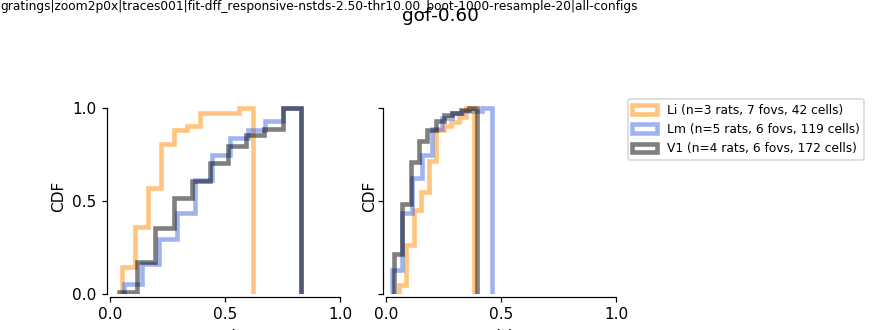

asi-dsi_all-configs-best_gof-0.60_cdf


In [189]:
#gof = 0.66
cdf = True
alpha = 0.5
filter_gof = True
if filter_gof:
    roi_str = 'gof-%.2f' % gof_thr
    rdata = gdata[gdata['gof'] >= gof_thr]
else:
    roi_str = 'all-cells'
    rdata = gdata.copy()

fig, axes = pl.subplots(1,2, sharex=True, sharey=True, figsize=(8,3))
fig.patch.set_alpha(1)

ax = axes[0]
compare_tuning_metric(rdata, metric='asi', cdf=cdf, area_colors=area_colors, ax=ax, show_legend=False, alpha=alpha)
ax = axes[1]
compare_tuning_metric(rdata, metric='dsi', cdf=cdf, area_colors=area_colors, ax=ax, alpha=alpha)

pl.subplots_adjust(wspace=0.2, right=0.7, top=0.7)
fig.suptitle(roi_str)
for ax in axes:
    ax.set_xlim([0, 1])
    ax.set_xticks([0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])
    sns.despine(ax=ax, trim=True, offset=2)
    
    
label_figure(fig, data_identifier)
figname = 'asi-dsi_all-configs-best_%s_%s' % (roi_str, 'cdf' if cdf else 'hist')
pl.savefig(os.path.join(destdir, '%s.png' % figname))
print figname

In [182]:
len(list(set(['-'.join([a, s, v]) for a, s, v in rdata[['animalid', 'session', 'fov']].values])))

19

In [192]:
rdata.shape

(333, 15)

In [193]:
gdata.shape

(333, 15)

<IPython.core.display.Javascript object>


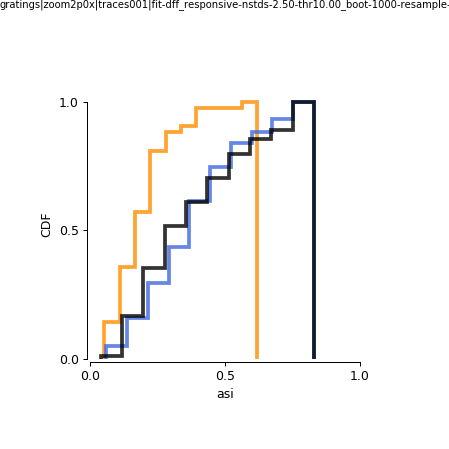

asi_all-configs-best_gof-0.60_cdf


In [62]:
#gof = 0.66
cdf = True
alpha = 0.5
filter_gof = True
if filter_gof:
    roi_str = 'gof-%.2f' % gof_thr
    rdata = gdata[gdata['gof'] >= gof_thr]
else:
    roi_str = 'all-cells'
    rdata = gdata.copy()

fig, ax = pl.subplots(figsize=(5,5))

fig.patch.set_alpha(1)

compare_tuning_metric(rdata, metric='asi', cdf=cdf, area_colors=area_colors, ax=ax, show_legend=False, alpha=0.8)

pl.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
#fig.suptitle(roi_str)
ax.set_xlim([0, 1])
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])
sns.despine(ax=ax, trim=True, offset=2)

    
label_figure(fig, data_identifier)
figname = 'asi_all-configs-best_%s_%s' % (roi_str, 'cdf' if cdf else 'hist')
pl.savefig(os.path.join(destdir, '%s.svg' % figname))
print figname

In [154]:
data_identifier

'gratings|zoom2p0x|traces001|fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20|all-configs'

<IPython.core.display.Javascript object>


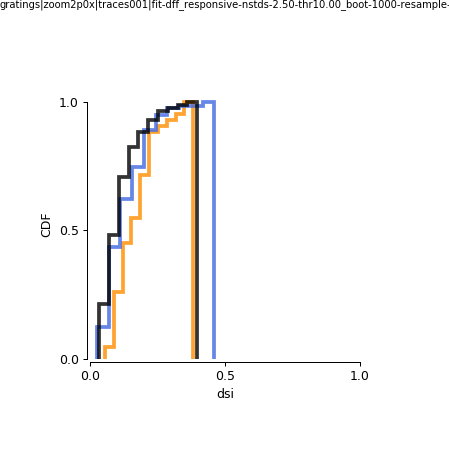

dsi_all-configs-best_gof-0.60_cdf


In [63]:

#gof = 0.66
cdf = True
alpha = 0.5
filter_gof = True
if filter_gof:
    roi_str = 'gof-%.2f' % gof_thr
    rdata = gdata[gdata['gof'] >= gof_thr]
else:
    roi_str = 'all-cells'
    rdata = gdata.copy()

fig, ax = pl.subplots(figsize=(5,5))

fig.patch.set_alpha(1)

compare_tuning_metric(rdata, metric='dsi', cdf=cdf, area_colors=area_colors, ax=ax, show_legend=False, alpha=0.8)

pl.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
#fig.suptitle(roi_str)
ax.set_xlim([0, 1])
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])
sns.despine(ax=ax, trim=True, offset=2)

    
label_figure(fig, data_identifier)
figname = 'dsi_all-configs-best_%s_%s' % (roi_str, 'cdf' if cdf else 'hist')
pl.savefig(os.path.join(destdir, '%s.svg' % figname))
print figname

<IPython.core.display.Javascript object>


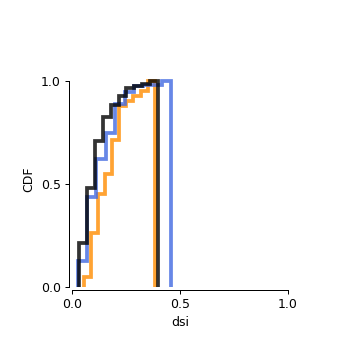

In [64]:


fig, ax = pl.subplots(figsize=(4, 4))
fig.patch.set_alpha(1)

compare_tuning_metric(rdata, metric='dsi', cdf=cdf, area_colors=area_colors, ax=ax, alpha=0.8, show_legend=False)

pl.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
#fig.suptitle(roi_str)
ax.set_xlim([0, 1])
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])
sns.despine(ax=ax, trim=True, offset=2)

# Look at other properties

In [65]:
import matplotlib.patches as mpatches


In [66]:
destdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/orientation-tuning/traces001-fit-dff_responsive-nstds-2.50-thr10.00_boot-1000-resample-20'

<IPython.core.display.Javascript object>


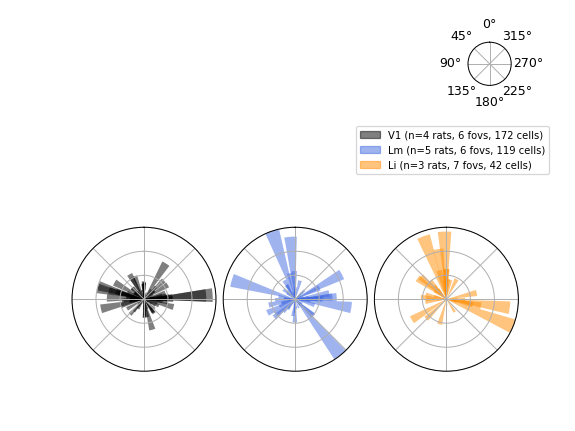

preferred-thetas_all-configs-best_gof-0.60


In [78]:
fig = pl.figure()
fig.patch.set_alpha(1)
#ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
lbs = []

ymax = 1.5
for vi, visual_area in enumerate(visual_areas):
    g = gdata.groupby(['visual_area']).get_group(visual_area) #enumerate(gdata.groupby(['visual_area'])):
    ax = pl.subplot(1,3,vi+1, projection='polar')
    tmpg = g.copy()
    radii = tmpg['response_pref'] #/tmpg['response_pref'].max()
    thetas = np.deg2rad( np.arange(0, 360, 45) )
    widths = np.deg2rad( tmpg['theta_pref'].values )

    nrats = len(tmpg['animalid'].unique())
    nfovs = len(tmpg['session'].unique())
    ncells = tmpg.count()[0]
    bars = ax.bar(widths, radii, width=.2, bottom=0.0, color=area_colors[visual_area])
    for r,bar in zip(radii, bars):
        bar.set_alpha(0.5)
    ax.set_theta_zero_location("N")
    ax.set_xticks(thetas)
    ax.set_xticklabels([''])
    ax.set_ylim([0, 1.5])
    #ax.set_yticks(np.linspace(0, 1.5, 5))
    ax.set_yticklabels([])
    #ax.set_yticklabels(['','', '', '', '']) #, '', 1])

    #ax.set_yticklabels(['','', '', '', 1.5]) #, '', 1])
    #ax.set_ylabel('dff')
    lbs.append('%s (n=%i rats, %i fovs, %i cells)' % (visual_area, nrats, nfovs, ncells))

pl.subplots_adjust(top=0.5, wspace=0.05)
# Legends
leg = fig.add_axes([0.8, 0.8, 0.1, 0.1], polar=True)
leg.set_yticks([])
leg.set_theta_zero_location("N")

legend_handles = [mpatches.Patch(color=area_colors[visual_area], label=lb, alpha=0.5)\
                  for visual_area, lb in zip(visual_areas, lbs)]
leg.legend(bbox_to_anchor=(2, -1.5), loc='right', ncol=1, handles=legend_handles, fontsize=8)

figname = 'preferred-thetas_all-configs-best_%s' % (roi_str)
pl.savefig(os.path.join(destdir, '%s.svg' % figname))
print figname

<IPython.core.display.Javascript object>


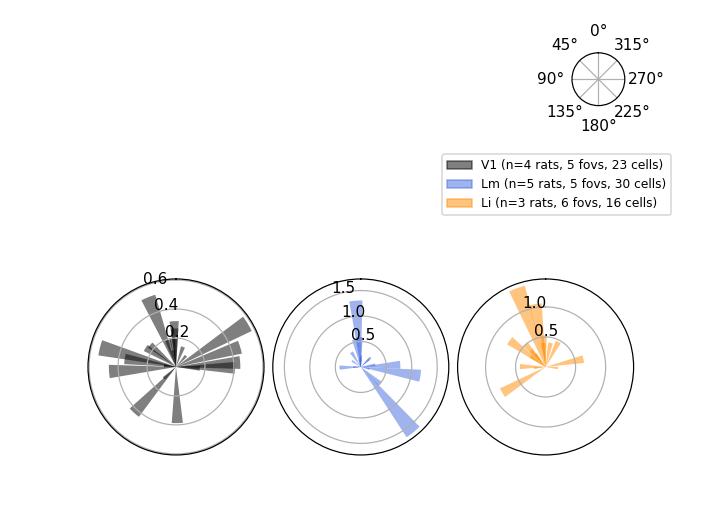

DS-preferrd-thetas_all-configs-best_gof-0.60


In [38]:
fig = pl.figure()
fig.patch.set_alpha(1)
#ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
lbs = []
for vi, visual_area in enumerate(visual_areas):
    g = gdata.groupby(['visual_area']).get_group(visual_area) #enumerate(gdata.groupby(['visual_area'])):
    ax = pl.subplot(1,3,vi+1, projection='polar')
    tmpg = g[g['dsi']>=0.2]
    radii = tmpg['response_pref'] #/tmpg['response_pref'].max()
    thetas = np.deg2rad( np.arange(0, 360, 45) )
    widths = np.deg2rad( tmpg['theta_pref'].values )

    nrats = len(tmpg['animalid'].unique())
    nfovs = len(tmpg['session'].unique())
    ncells = tmpg.count()[0]
    bars = ax.bar(widths, radii, width=.2, bottom=0.0, color=area_colors[visual_area])
    for r,bar in zip(radii, bars):
        bar.set_alpha(0.5)
    ax.set_theta_zero_location("N")
    ax.set_xticks([])
    #ax.set_yticks(np.linspace(0, 1, 5))
    #ax.set_yticklabels(['']) #, '', 1])
    #ax.set_ylabel('dff')
    lbs.append('%s (n=%i rats, %i fovs, %i cells)' % (visual_area, nrats, nfovs, ncells))

pl.subplots_adjust(top=0.5, wspace=0.05)
# Legends
leg = fig.add_axes([0.8, 0.8, 0.1, 0.1], polar=True)
leg.set_yticks([])
leg.set_theta_zero_location("N")

legend_handles = [mpatches.Patch(color=area_colors[visual_area], label=lb, alpha=0.5)\
                  for visual_area, lb in zip(visual_areas, lbs)]
leg.legend(bbox_to_anchor=(2, -1.5), loc='right', ncol=1, handles=legend_handles, fontsize=8)

figname = 'DS-preferrd-thetas_all-configs-best_%s' % (roi_str)
pl.savefig(os.path.join(destdir, '%s.png' % figname))
print figname

In [69]:
widths.max()

5.1628055060276825

<IPython.core.display.Javascript object>


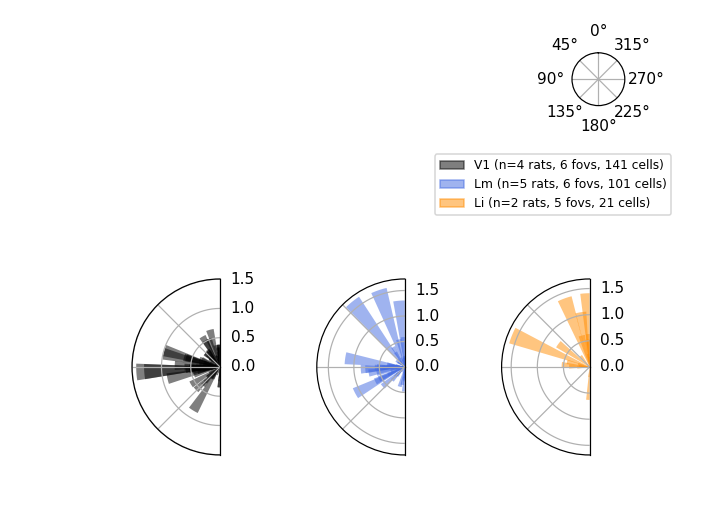

AS-preferrd-thetas_all-configs-best_gof-0.60


In [39]:
fig = pl.figure()
fig.patch.set_alpha(1)
#ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
lbs = []
for vi, visual_area in enumerate(visual_areas):
    g = gdata.groupby(['visual_area']).get_group(visual_area) #enumerate(gdata.groupby(['visual_area'])):
    ax = pl.subplot(1,3,vi+1, projection='polar')
    tmpg = g[g['asi']>=0.2]
    radii = tmpg['response_pref'] #/tmpg['response_pref'].max()
    thetas = np.deg2rad(np.arange(0, 180+45, 45))
    widths = np.deg2rad(tmpg['theta_pref'] % 180.)

    nrats = len(tmpg['animalid'].unique())
    nfovs = len(tmpg['session'].unique())
    ncells = tmpg.count()[0]
    bars = ax.bar(widths, radii, width=.2, bottom=0.0, color=area_colors[visual_area])
    for r,bar in zip(radii, bars):
        bar.set_alpha(0.5)
    ax.set_theta_zero_location("N")
    ax.set_xticks(thetas)
    ax.set_xticklabels([''])
    ax.set_xlim([thetas[0], thetas[-1]])
    #ax.set_yticks(np.linspace(0, 1, 5))
    #ax.set_yticklabels(['']) #, '', 1])
    lbs.append('%s (n=%i rats, %i fovs, %i cells)' % (visual_area, nrats, nfovs, ncells))

pl.subplots_adjust(top=0.5, wspace=0.05)
# Legends
leg = fig.add_axes([0.8, 0.8, 0.1, 0.1], polar=True)
leg.set_yticks([])
leg.set_theta_zero_location("N")

legend_handles = [mpatches.Patch(color=area_colors[visual_area], label=lb, alpha=0.5)\
                  for visual_area, lb in zip(visual_areas, lbs)]
leg.legend(bbox_to_anchor=(2, -1.5), loc='right', ncol=1, handles=legend_handles, fontsize=8)

figname = 'AS-preferrd-thetas_all-configs-best_%s' % (roi_str)
pl.savefig(os.path.join(destdir, '%s.png' % figname))
print figname

In [53]:
thetas

array([  0,  15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165])

In [59]:
ax.get_xticks()

array([0.        , 0.78539816, 1.57079633, 2.35619449, 3.14159265,
       3.92699082, 4.71238898, 5.49778714])